In [1]:
import numpy as np
import pandas as pd
import FinanceDataReader as fdr
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
from sklearn.metrics.pairwise import linear_kernel

In [2]:
# matplotlib rebuild

import matplotlib.pyplot as plt
from matplotlib import font_manager
%matplotlib inline


font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()

plt.rcParams["font.family"] = font_family
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["axes.formatter.limits"] = -10000, 10000


In [3]:
df = pd.read_csv('./data/preprocessing/preprocessed/df_tokenized.csv',index_col=0)

#### 사업보고서 fillings_month 체크

In [46]:
len(rcp_df[rcp_df.발행월 =='02'])

1

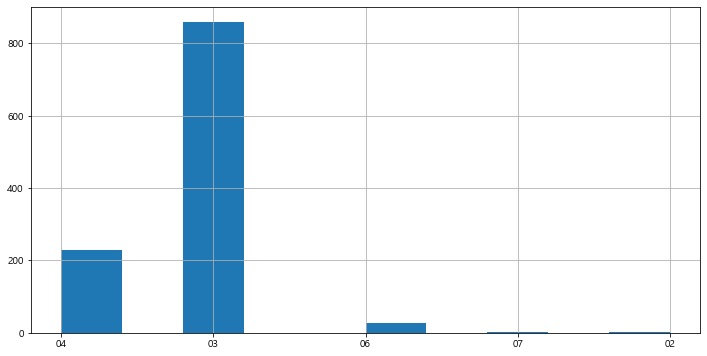

In [4]:
rcp_month = [str(x)[4:6] for x in df.rcp_dt]
rcp_df = pd.DataFrame(rcp_month,columns={'발행월'})
hist = plt.hist(rcp_df.발행월,bins = None)
plt.show()

## wordcount

In [5]:
def word_count(ls):  #document의 word count
    ls = ls.split()
    counts = dict()
    for word in ls:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
            
    return counts


In [6]:
def total_word_count(srs): #total document의 word count
    ls = [x.split() for x in srs]
    counts = dict()
    for doc in ls:
        for word in doc:
            if word in counts:
                counts[word] += 1
            else:
                counts[word] = 1
    return counts

In [25]:
tokens_dic = total_word_count(df.str_tokens)
nouns_dic = total_word_count(df.str_nouns)
tfd_tokens = pd.DataFrame(tokens_dic.items(),columns = ['단어','빈도']).sort_values('빈도',ascending=False).reset_index(drop=True)
tfd_nouns = pd.DataFrame(nouns_dic.items(),columns = ['단어','빈도']).sort_values('빈도',ascending=False).reset_index(drop=True)

In [28]:
tfd_nouns.head(10)

,단어,빈도
0,사업,20699
1,증가,19186
2,회사,15722
3,대비,15358
4,자산,12939
5,영업,12742
6,당사,12653
7,사항,12569
8,전년,10965
9,시장,10718


In [29]:
tfd_nouns.tail(10)

,단어,빈도
9855,재무장,1
9856,환골탈태,1
9857,덤핑,1
9858,도실,1
9859,쉼,1
9860,시프,1
9861,카바이드,1
9862,달러환,1
9863,사염화규소,1
9864,동비,1


### Wordcloud

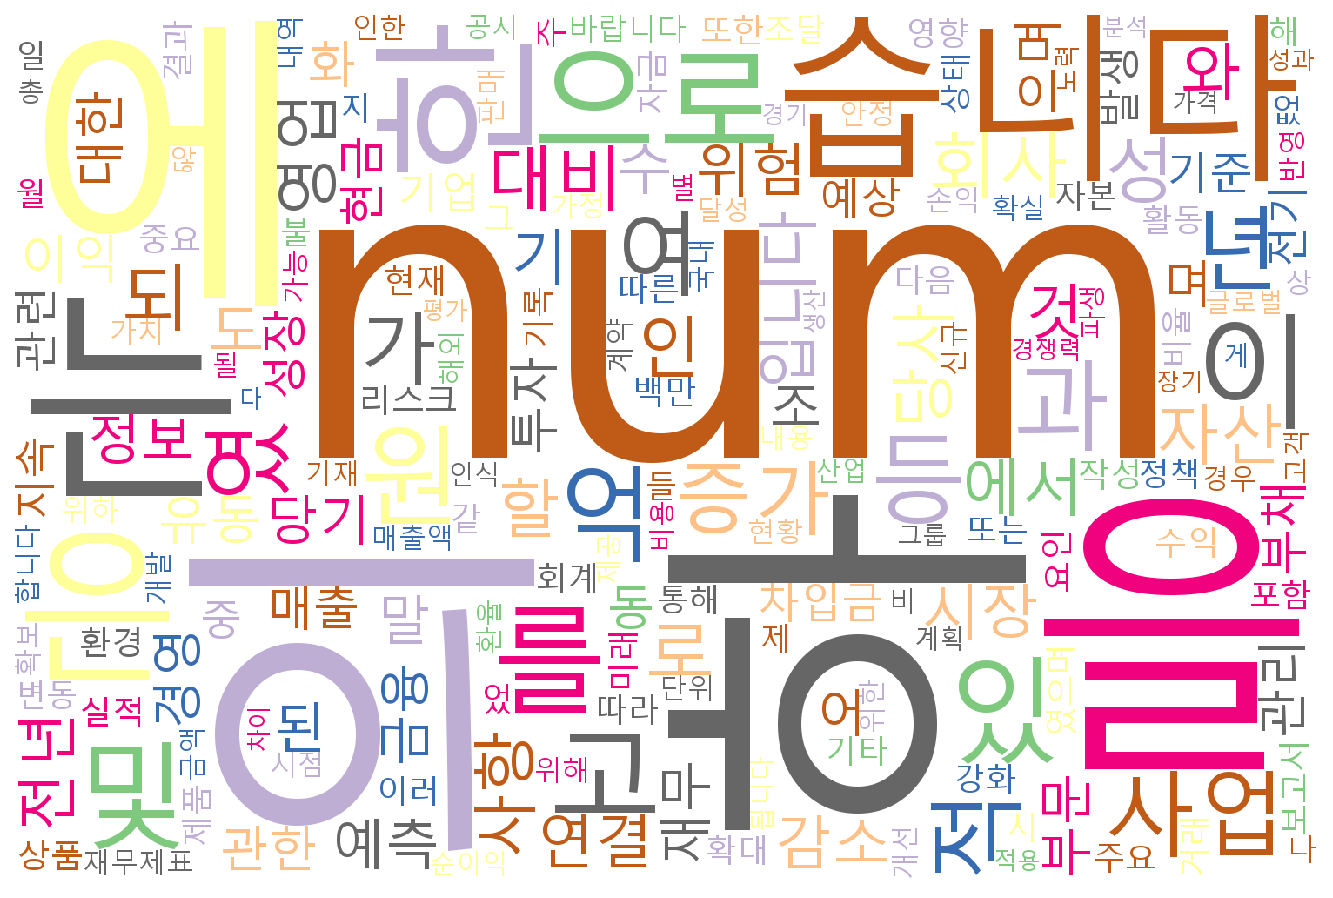

In [30]:
from wordcloud import WordCloud #wordcloud 생성
from IPython.display import set_matplotlib_formats
import matplotlib

matplotlib.rc('font',family = 'Malgun Gothic')
set_matplotlib_formats('retina')
matplotlib.rc('axes',unicode_minus = False)
plt.rcParams["figure.figsize"] = (15,8)
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white',colormap = "Accent_r",
            width=1500, height=1000).generate_from_frequencies(tokens_dic) #여기에 dic형태넣어주기

plt.imshow(wordcloud)
plt.axis('off')
plt.show;

## Document size check

In [9]:
print(df.shape)
print(tfd_tokens.shape)
print(tfd_nouns.shape)

(1117, 9)
(14198, 2)
(9865, 2)


dataset은 10년동안 kospi200에 계속 편입되어있던 113개의 기업의 발간 사업보고서들인 1117개의 Documents입니다.
Mecab으로 형태소분석을 했을 때 총 토큰들과 그 중 명사만 뽑아 term document freqeuncy를 빈도가 높은 순 대로 살펴보았는데 각각 14198, 9865개의 단어 수를 기록했습니다. 형태소분석 단어집합들은 숫자를 치환한 'num'와 조사가 빈도수가 가장 많았습니다.


다음으로는 조사와 num을 제외하여 단어 count를 살펴보고, tfd_nouns와 비교 후 이를 documnet filings 연도별로 매칭시켜 연도별 word counts의 frequency를 살펴보도록 하자.

In [10]:
df_count = df.copy()
df_count = df_count.loc[:,['연도','crp_nm','rpt_nm']]
word_count_ls = [len(word_count(x).items()) for x in df.str_tokens]
word_count_noun_ls = [len(word_count(x).items()) for x in df.str_nouns]
df_count['document_size'] = word_count_ls
df_count['document_noun_size'] = word_count_noun_ls

In [11]:
df_count.document_size.describe()

count    1117.000000
mean      533.700090
std       261.591933
min        26.000000
25%       372.000000
50%       479.000000
75%       629.000000
max      1939.000000
Name: document_size, dtype: float64

In [12]:
df_count = df_count.sort_values(by = '연도')
year_ls = [sum(df_count[df_count.연도 == x].document_size) for x in df_count.연도.unique()]
year_noun_ls = [sum(df_count[df_count.연도 == x].document_noun_size) for x in df_count.연도.unique()]
doc_size_by_year = pd.DataFrame(list(zip(df_count.연도.unique(),year_ls,year_noun_ls)),columns= ['year','document','noun'])
doc_size_by_year = doc_size_by_year.sort_values(by = 'year', ascending= True).reset_index(drop=True)

In [13]:
doc_size_by_year

,year,document,noun
0,2010,49508,33040
1,2011,50372,33795
2,2012,56123,38041
3,2013,57949,39411
4,2014,58837,40150
5,2015,61647,42472
6,2016,60458,41609
7,2017,61814,42627
8,2018,67358,46905
9,2019,72077,50436


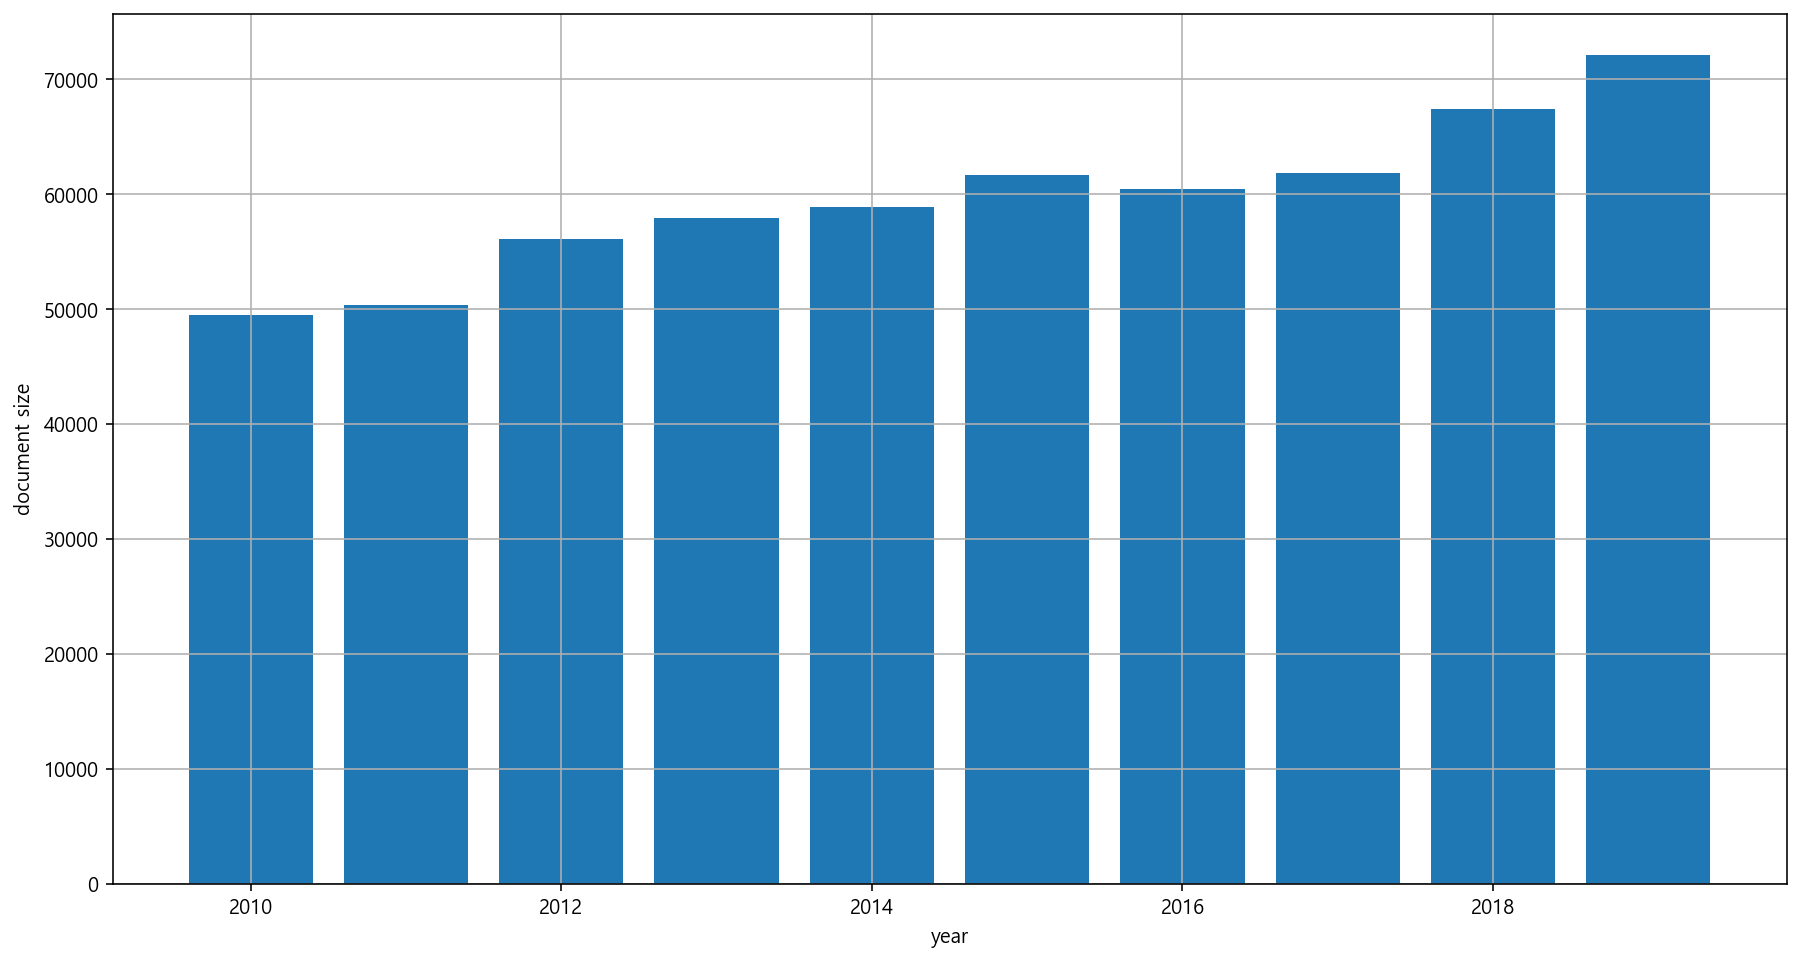

In [14]:
import matplotlib.pyplot as plt

plt.bar(doc_size_by_year.year, doc_size_by_year.document)

plt.xlabel('year')
plt.ylabel('document size')
plt.show()

Similarity_Cohen_Malloy_Nguyen(2019)Lazy Prices의 내용과 마찬가지로 미국 뿐만 아니라 한국에서도 10년간 사업보고서 내의 단어 빈도가 꾸준히 증가하였다. 토큰화된 사업보고서의 텍스트를 기준으로 하였으며 명사로 봤을 때도 단조 증가하는 양상은 동일하였다.

## Document Similarity


Document의 유사도를 계산하기 위해서 논문에서 다루고 있는 Jaccard similarity 외에 Cosine similarity가 있다. 코사인 유사도는 두 벡터 간의 사잇각의 크기를 측정하여 유사도를 측정하는 방법이다. 텍스트마이닝에서는 각각의 document D1 , D2가 벡터로 표현되고.. D1의 term frequency만큼의 차원을 가진 벡터 V1으로 표현이 될 것이다. 연산을 위해서는 D1과 D2의 차원이 같아야 하므로 사업보고서의 단어수는 각각 다르기 떄문에 padding을 시켜줄 필요가 있다. 공식은 간단하게 분자는 각각의 벡터들의 내적, 분모는 두 벡터의 크기의 곱을 Euclidian distance로 구해주면 된다.

단순하게 단어 set의 교집합을 합집합으로 나누는 자카드 유사도보다는 문서의 의미론적인 유사도 파악에 있어서 이점이 있는지는 정확하게 모르겠지만 수치상으로 비교했을 때 코사인 유사도가 더 높은 것 같다.

텍스트마이닝에서 사이킷런의 패키지도 그렇고  TF-IDF를 가지고 코사인 유사도 계산을 하는데 TF-IDF란 TF(term frequency)에 IDF(inverse document frequency)를 곱한 것이다. 아이디어의 핵심은 단순히 단어의 빈도가 많다고 그 단어가 중요한 단어가 아니라 특정 문서(document)에서 많이 등장하는 단어인지 아니면 모든 문서에서 많이 등장하는 단어인지를 파악하여 weight를 줘야 한다는 것이다. 가령 한글의 조사 ‘은’이나 ‘가’는 형태소 토큰화를 했을때 빈번하게 등장하는 토큰일 것이지만 문서들간의 유사도를 따지는 데 있어서 중요한 단어라고 보기 어렵다. 
IDF는 N/df에 log를 씌워줘서 계산한다. 확률의 개념을 사용하여 원래는 N( 등장한 document의 총 수)를 실제 term이 등장한 document의 수인 df로 나눠준 것인데 이를 inverse하여 log를 씌웠다. 로그를 씌운 것은 곱셈계산을 더해서 할수있고 빈도가 가장 많이 나오는 단어들은 그렇지 않은 단어들에 비해 거의 2배씩 증가하면서 많아지기 때문에 이를 보정하기 위한 정규화 방법이라고 볼 수 있다.


In [15]:
def length_adjust(str_) : 
    return (2-len(str_)) * '0' + str_

def date_convertor(date) : 
    year = length_adjust(str(date.year))
    month = length_adjust(str(date.month))
    day = length_adjust(str(date.day))
    yyyymmdd = int(year+month+day)
    return yyyymmdd

In [16]:
def cal_sim(df,type_):
    
    
    naive_df = df.copy()
    lv2_index = pd.date_range(start='20100101', end='20191231')
    lv2_index = list(map(date_convertor,lv2_index))
    lv2_columns = naive_df.crp_nm.unique()

    lv2_df = \
    pd.DataFrame(np.full(shape=(len(lv2_index),len(lv2_columns)),fill_value=np.nan),index=lv2_index,columns=lv2_columns)
    
    for process,corp_name in enumerate(lv2_columns):
        print("Process : {} | Total : {}".format(process+1,len(lv2_columns)),end='\r')

        tmp_df = naive_df[naive_df.crp_nm == corp_name]

        min_yr = tmp_df['연도'].min() #2010
        max_yr = tmp_df['연도'].max() #2019

        tmp_tf = tfidf.fit_transform(tmp_df.str_tokens) #vectorize as matrix
        tmp_cosine = linear_kernel(tmp_tf,tmp_tf)

        sim_ls = []; year_ls = []

        for yr in range(min_yr,max_yr) :

            pre_df = tmp_df[tmp_df['연도'] == yr]
            next_df = tmp_df[tmp_df['연도'] == yr+1]

            publish_date = tmp_df[tmp_df['연도'] == yr+1]['rcp_dt']

            if len(pre_df) == 0 or len(next_df) ==0:
                continue

            else:
                if type_ == 'cosine':
                    concat_df = pd.concat([pre_df,next_df]) 
                    co_vec = tfidf.fit_transform(concat_df.str_nouns)
                    sim = linear_kernel(co_vec)[1][0]
                    
                elif type_ == 'jaccard':
                    pre_token = pre_df.str_tokens.map(lambda x : x.split(" ")).values
                    next_token = next_df.str_tokens.map(lambda x : x.split(" ")).values   
                    if type(pre_token[0]) == list and type(next_token[0]) == list :
                        sim = len(set(next_token[0])&set(pre_token[0]))/len(set(next_token[0] + pre_token[0]))
                    else : 
                        sim = len(set(next_token)&set(pre_token))/len(set(next_token + pre_token))
                    

            year_ls.append(publish_date.values[0])
            sim_ls.append(sim)

            assert len(year_ls) == len(sim_ls)
            lv2_df.loc[year_ls,corp_name] = sim_ls
    
    return lv2_df

In [17]:
%%time
cosine_df = cal_sim(df,'cosine')
jaccard_df = cal_sim(df,'jaccard')

Wall time: 17.1 sotal : 113


In [18]:
print(jaccard_df.mean().mean())
print(cosine_df.mean().mean())

0.6590837093668442
0.8491577150668567


In [19]:
cos_ls = []
jac_ls = []
for i in cosine_df.columns:
    for j in cosine_df.index:
        if cosine_df.loc[j,i] > 0:
            cos_ls.append(cosine_df.loc[j,i])
    
for i in jaccard_df.columns:
    for j in jaccard_df.index:
        if jaccard_df.loc[j,i] > 0:
           jac_ls.append(jaccard_df.loc[j,i])
        
sim_df = pd.DataFrame([jac_ls,cos_ls],index={'jaccard','cosine'})
sim_df = sim_df.T

sim_df.corr(method='pearson')

,jaccard,cosine
jaccard,1.000000,0.794961
cosine,0.794961,1.000000


In [20]:
cosine_df[cosine_df.loc[:,'삼양홀딩스'].isnull() != True]

,삼양홀딩스,유한양행,CJ대한통운,두산,대림산업,한국테크놀로지그룹,기아차,동아쏘시오홀딩스,SK하이닉스,영풍,...,현대백화점,한국금융지주,GS,하나금융지주,아모레퍼시픽,LF,후성,SK이노베이션,CJ제일제당,KB금융
20110331,0.622024,NaN,0.773160,0.912678,0.841253,0.431589,0.920595,NaN,0.797388,0.806065,...,0.962223,NaN,NaN,0.748002,0.749037,NaN,0.792693,0.789827,0.934788,0.950537
20120330,0.434998,0.873114,0.801449,0.842174,0.807316,0.853189,0.694075,0.540498,0.702372,0.631874,...,NaN,NaN,0.781712,0.963943,0.771763,0.910761,0.788836,0.485055,0.800814,0.954953
20130401,0.778899,NaN,NaN,NaN,0.932009,0.626158,0.808872,0.839238,NaN,0.769667,...,0.881104,NaN,NaN,0.948453,0.790564,NaN,0.677898,0.788815,0.927363,NaN
20140331,0.874241,0.885923,0.831608,0.759681,0.923337,0.953803,0.926286,0.769244,0.981531,0.731935,...,0.894385,0.624280,0.882901,0.952799,0.891831,0.537132,0.685722,0.844073,0.936276,0.974530
20150331,0.893520,0.929097,0.879566,0.949291,0.936706,0.958228,0.938524,0.655989,0.231396,0.958960,...,0.889942,0.954915,0.621349,0.928968,0.839272,0.983096,0.943338,0.953768,0.888349,0.971369
20160330,0.898578,0.806710,0.818457,0.950590,0.902032,0.975595,0.966084,0.864378,0.516489,0.925520,...,0.916792,0.818755,0.956766,0.957387,0.743325,0.895004,0.889216,0.922507,0.725712,0.979348
20170331,0.836248,0.963508,0.821509,0.953412,0.907106,0.751839,0.925390,0.960596,0.782483,0.913526,...,0.935313,0.899389,0.970278,0.951446,0.826123,NaN,0.959064,0.973943,0.808266,0.970944
20180402,0.798907,0.878734,0.844829,NaN,NaN,0.922530,0.883183,0.927719,0.543521,0.934352,...,0.842583,0.813153,0.968133,0.966075,0.858522,NaN,0.865815,0.966110,NaN,0.966590
20190401,0.919519,0.791413,0.951014,NaN,0.693943,0.856799,0.900001,0.891740,NaN,0.869888,...,0.945849,0.899971,0.974630,0.988352,0.827661,0.902945,0.942776,0.989362,0.847765,0.972680


사업보고서의 유사도를 비교하기 위해 자카드 유사도와 코사인 유사도 두가지 방법으로 유사도를 측정하여 dataframe 형태로 저장하였다.

columns는 113개의 기업들, index는 2010년부터 2019년까지의 일별날짜로 사업보고서가 첫 번쨰로 filing된 날짜인 rcp_dt에 전년도와 다음년도 사업보고서의 유사도를 저장하였다. 만약 10년에 처음 보고서가 나오고 다음해인 11년 3월 31일에 다음 사업보고서가 나왔다면 20110331의 인덱스에 2010년과 2011년 보고서의 유사도값을 저장하였다. 연속된 해에 보고서가 한번이라도 없으면 이를 배제하였고 총 1000개의 유사도값이 나왔다.

자카드 유사도의 평균값은 0.66, 코사인 유사도의 평균값은 0.85이다. 코사인 유사도를 계산하는 공식에는 조금씩 차이가 있지만 보편적으로 쓰이는 사이킷런 패키지의  tf-idf 벡터화를 실행한 후 이들의 코사인 값을 계산했다.

자카드와 코사인 유사도로 계산한 값들의 correlation은 0.794961이다.


